In [1]:
import random
import numpy as np
import matplotlib as plt
import pandas as pd
from PIL import Image
import os
import cv2
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder

In [2]:
SIZE_Y = 40*2
SIZE_X = 60*2

#Define Functions and Classes

def createLine(walls, SIZE_Y, SIZE_X):
    #Full Horizontal Line
    # for i in range(SIZE_X):
    #     walls[int(SIZE_Y/2),int(i)] = 1
        
    #Full Vertical Line
    # for i in range(SIZE_Y):
        # walls[int(i), int(SIZE_X/2)] = 1

    #Segment 1
    for i in range(SIZE_Y//10, SIZE_Y//3):
        walls[i, SIZE_X//2] = 1

    #Segment 2
    for i in range(SIZE_X//2, SIZE_X//2+SIZE_X//6):
        walls[SIZE_Y//10, i] = 1

    #Segment 3
    for i in range(SIZE_Y//10, SIZE_Y//4):
        walls[i, SIZE_X//2+SIZE_X//6] = 1

    #Segment 4
    for i in range(SIZE_X//2-SIZE_X//6, SIZE_X//2+1):
        walls[SIZE_Y//3, i] = 1

    #Segment 5
    for i in range(SIZE_Y//3, SIZE_Y//3+SIZE_Y//4):
        walls[i, SIZE_X//2-SIZE_X//6] = 1

    #Segment 6
    for i in range(SIZE_X//2-SIZE_X//6, SIZE_X//2+SIZE_X//6):
        walls[SIZE_Y//3+SIZE_Y//4, i] = 1
        
    #Segment 7
    for i in range(SIZE_Y//3+SIZE_Y//4, SIZE_Y//3+SIZE_Y//4+SIZE_Y//5):
        walls[i, SIZE_X//2+SIZE_X//6] = 1

    #Segment 8
    for i in range(SIZE_X//2+SIZE_X//6, SIZE_X//2+SIZE_X//6+SIZE_X//6):
        walls[SIZE_Y//3+SIZE_Y//4+SIZE_Y//5, i] = 1

    #Segment 9
    for i in range(SIZE_Y-SIZE_Y//3, SIZE_Y):
        walls[i, SIZE_X//2] = 1
        
    #Segment 10
    for i in range(SIZE_Y-SIZE_Y//4, SIZE_Y):
        walls[i, SIZE_X//2-SIZE_X//4] = 1

    #Segment 11
    for i in range(0, SIZE_X//6):
        walls[SIZE_Y//5, i] = 1

    #Segment 12
    for i in range(SIZE_Y//5, SIZE_Y//5+SIZE_Y//5):
        walls[i, SIZE_X//6] = 1

    #Segment 13
    for i in range(0, SIZE_X//6):
        walls[SIZE_Y//5+SIZE_Y//3, i] = 1
        
    #Segment 14
    for i in range(0, SIZE_Y//3):
        walls[i, SIZE_X-SIZE_X//6] = 1

    #Segment 15
    for i in range(SIZE_X-SIZE_X//10, SIZE_X):
        walls[SIZE_Y//3, i] = 1

    #Segment 16
    for i in range(SIZE_X-SIZE_X//9, SIZE_X):
        walls[SIZE_Y//2+SIZE_Y//10, i] = 1

    #Segment 17
    for i in range(SIZE_Y//2+SIZE_Y//10, SIZE_Y//2+SIZE_Y//10+SIZE_Y//4):
        walls[i, SIZE_X-SIZE_X//9] = 1
        
    #Segment 18
    for i in range(SIZE_Y//2+SIZE_Y//10+SIZE_Y//3, SIZE_Y):
        walls[i, SIZE_X-SIZE_X//9] = 1
    
    return walls

class EnvObject:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return f"{self.x}, {self.y}"
    
    def __sub__(self, other):
        return (self.x - other.x, self.y - other.y)
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
class Drone(EnvObject):
    def __init__(self, x, y):
        super().__init__(x, y)
        
    def action(self, choice):
        '''
        Gives us 9 total movement options. (0,1,2,3,4,5,6,7,8)
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)

        elif choice == 4:
            self.move(x=1, y=0)
        elif choice == 5:
            self.move(x=-1, y=0)

        elif choice == 6:
            self.move(x=0, y=1)
        elif choice == 7:
            self.move(x=0, y=-1)

        elif choice == 8:
            self.move(x=0, y=0)

    def move(self, x=False, y=False):

        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y


        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > SIZE_X-1:
            self.x = SIZE_X-1
        if self.y < 0:
            self.y = 0
        elif self.y > SIZE_Y-1:
            self.y = SIZE_Y-1

class Target(EnvObject):
    def __init__(self, x, y):
        super().__init__(x, y)

class DroneEnv:
    #Define Parameters
    SIZE_Y = 40*2
    SIZE_X = 60*2
    ENV_COLOR = (20, 52, 89)
    WALLS_COLOR = (77, 77, 234)
    DRONE_COLOR = (234, 222, 53)
    TARGET_COLOR = (132, 234, 53)
    space = np.zeros((SIZE_Y, SIZE_X, 3), dtype=np.uint8) 
    walls = np.zeros((SIZE_Y, SIZE_X), dtype=np.uint8)
    walls = createLine(walls, SIZE_Y, SIZE_X)


    def initial(self):
        self.agent_1 = Drone(self.SIZE_X-self.SIZE_X//11, self.SIZE_Y//10)
        self.agent_2 = Drone(self.SIZE_X-self.SIZE_X//20, self.SIZE_Y//2-self.SIZE_Y//20)
        self.agent_3 = Drone(self.SIZE_X-self.SIZE_X//13, self.SIZE_Y-self.SIZE_Y//11)
        self.target = Target(self.SIZE_X//10, self.SIZE_Y//2-self.SIZE_Y//20)
        
        self.episode_step = 0
        # observation = (self.agent_1.x - self.target.x) + (self.agent_1.y - self.target.y) + np.sqrt((self.agent_1.x - self.target.x)**2 + (self.agent_1.y - self.target.y)**2)
        observation = np.array([self.agent_1.x - self.target.x, self.agent_1.y - self.target.y, np.sqrt((self.agent_1.x - self.target.x)**2 + (self.agent_1.y - self.target.y)**2)])
        
        return observation
    
    def step(self, action, observation):
        self.episode_step += 1
        self.agent_1.action(action)
        
        new_observation = np.array([self.agent_1.x - self.target.x, self.agent_1.y - self.target.y, np.sqrt((self.agent_1.x - self.target.x)**2 + (self.agent_1.y - self.target.y)**2)])
        
        if self.agent_1 == self.target:
            reward = 100
            done = True
        elif self.episode_step >= 200:
            reward = -10
            done = True
        elif new_observation[2] < observation[2]:
            reward = 1
            done = False
        elif new_observation[2] > observation[2]:
            reward = -1
            done = False
            
        return new_observation, reward, done
        
    def is_wall(self, action):
            if self.walls[self.agent_1.y+action][self.agent_1.x+action] == 1:
                return True
    
    def visualize(self):
        for i in range(self.SIZE_Y):
            for j in range(self.SIZE_X):
                if self.walls[i][j] == 1:
                    self.space[i][j] = self.WALLS_COLOR
                else:
                    self.space[i][j] = self.ENV_COLOR

        self.space[self.agent_1.y][self.agent_1.x] = self.DRONE_COLOR
        self.space[self.target.y][self.target.x] = self.TARGET_COLOR
        
    def render(self):
        img = Image.fromarray(self.space, 'RGB')
        img = img.resize((1200, 800), resample = Image.Resampling.BOX)
        cv2.imshow("image", np.array(img))  # show it!
        cv2.waitKey(0)
        cv2.destroyAllWindows()

#crete the environment
env = DroneEnv()

In [3]:
map = env.walls
print(map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [4]:
env.initial()
target = [env.target.x, env.target.y]
agent_1 = [env.agent_1.x, env.agent_1.y]
print("Target Pos:",target)
print("Agent Pos:",agent_1)

Target Pos: [12, 36]
Agent Pos: [110, 8]


### Render Map

In [5]:
print(env.initial())
observation = env.initial()
next_state, reward, done = env.step(1, observation)
print(next_state, reward, done)
env.visualize()
env.render()

[ 98.         -28.         101.92153845]
[ 97.         -29.         101.24228366] 1 False


# Calculation

## Shortest Path Distance

Create vars

In [12]:
grid = Grid(matrix=np.logical_not(map))
start = grid.node(agent_1[0],agent_1[1])
end = grid.node(target[0],target[1])

In [13]:
finder = AStarFinder(diagonal_movement=DiagonalMovement.always)
path, runs = finder.find_path(start, end, grid)

In [14]:
print('operations:', runs, 'path length:', len(path))
print(grid.grid_str(path=path, start=start, end=end))

operations: 2642 path length: 107
+------------------------------------------------------------------------------------------------------------------------+
|                                                                                                    #                   |
|                                                                                                    #                   |
|                                                                                                    #                   |
|                                                                                                    #                   |
|                                                                                                    #                   |
|                                                                                                    #                   |
|                                                                                                    #   

### Looping for each grid

In [9]:
pathDist = np.zeros_like(map)
pathDist.shape

(80, 120)

In [21]:
for i in range(pathDist.shape[0]):
    for j in range(pathDist.shape[1]):
        if map[i,j] == 1:
            pathDist[i,j] = 0
        else:
            # init pathfinder
            grid = Grid(matrix=np.logical_not(map))
            end = grid.node(x=target[0],y=target[1])
            start = grid.node(j,i)
            finder = AStarFinder(diagonal_movement=DiagonalMovement.always)
            path, runs = finder.find_path(start, end, grid)

            # Calculate path length (NOT path array length)
            length = 0
            for k in range(len(path)-1):
                length += np.sqrt((path[k][0] - path[k+1][0])**2 + (path[k][1] - path[k+1][1])**2)
            print('grid: ['+str(i)+','+str(j)+'] operations:', runs, 'path length:{:.2f}'.format(length))
            pathDist[i,j] = length
            
            

grid: [0,0] operations: 369 path length:53.70
grid: [0,1] operations: 369 path length:52.70
grid: [0,2] operations: 369 path length:51.70
grid: [0,3] operations: 369 path length:50.70
grid: [0,4] operations: 369 path length:49.70
grid: [0,5] operations: 369 path length:48.70
grid: [0,6] operations: 376 

: 

: 

In [ ]:
# DF = pd.DataFrame(pathDist)
# DF.to_csv('pathDist.csv', index=False, header=False)
# print(pathDist)

# Visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

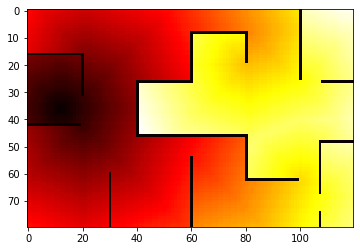

In [6]:
pathDist = pd.read_csv('pathDist.csv', header=None, dtype='int32')
plt.imshow(pathDist, cmap='hot', interpolation='nearest')